**Code References:**

[1] Part of the VGG code is taken from https://www.kaggle.com/adi160/cifar-10-keras-transfer-learning/

[2] SonoNet-Modified VGG with BNN from https://github.com/baumgach/SonoNet-weights



**Scientific References**:

[1] [Attention Bilinear Pooling for Fine-Grained Classification](https://www.mdpi.com/2073-8994/11/8/1033/htm)

[2] [Deconvolution Checkerboard Artifacts](https://distill.pub/2016/deconv-checkerboard/)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset_path = '/content/drive/MyDrive/Work\ Docs/AMMACHI\ Labs/Cropped/HW_V4_raw_cropped_with_seg_maps.tar'
dataset_path = '/content/drive/MyDrive/Handwash-Bot-Thesis/Datasets/Kaggle/Cropped/HW_V4_raw_cropped_with_seg_maps.tar'

In [ ]:
# Handwashing Dataset
!tar -xf $dataset_path -C /content/

In [ ]:
!pip install tf-keras-vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.8 MB/s 


In [ ]:
from shutil import copyfile
import glob
import matplotlib.image as mpimg
import seaborn as sns
from tensorflow.image import random_contrast, random_brightness
from tensorflow.image import adjust_contrast, adjust_brightness
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
# Models, layers and Datagens
import tensorflow as tf
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.layers import BatchNormalization, LocallyConnected2D
from tensorflow.keras.layers import Lambda, multiply
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback
from keras.layers import Lambda, Activation,Input, Multiply,BatchNormalization, Activation, Reshape, MaxPooling2D, concatenate, UpSampling2D, Dropout,Concatenate,Dense, GlobalAveragePooling2D, GlobalMaxPool2D

# Image Processing
import cv2
import numpy as np
from tensorflow.image import random_contrast, random_brightness
from tensorflow.image import adjust_contrast, adjust_brightness
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.image as mpimg

# Visualization 
import pandas as pd
from matplotlib import pyplot as plt
from tf_keras_vis.utils import num_of_gpus
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize, standardize
from tensorflow.keras import backend as K

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


# Misc
from collections import deque
import pickle
import os
import random
from math import ceil
from pathlib import Path
import shutil

In [ ]:
from tensorflow.keras import Sequential
'Importing pretrained models'
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

'Importing the final layers that will be added on top of the base model'
from tensorflow.keras.layers import Input, Flatten, Dense, multiply, BatchNormalization, Lambda, Activation, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D

from tensorflow.keras.models import Model

'Datagenerator to augment images'
from tensorflow.keras.preprocessing.image import ImageDataGenerator

'Import to_categorical for one hot encoding the labels'
from tensorflow.keras.utils import to_categorical



In [ ]:
%tensorflow_version 2.x
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
!nvidia-smi -L

2.8.2
/device:GPU:0
Num GPUs Available:  1
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-29ca78f4-82f0-eea4-1937-5009fe915914)


In [ ]:
timg = cv2.imread('/content/HW_V4_raw_cropped_with_seg_maps/samples/Step_1/HandWash_001_A_01_G_01_0005.jpg')

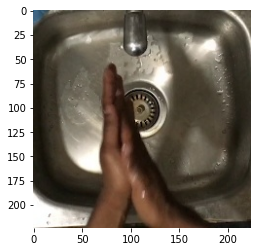

In [ ]:
plt.imshow(cv2.cvtColor(timg, cv2.COLOR_BGR2RGB))
plt.box(False)

In [ ]:
np.shape(timg)

(224, 224, 3)

## Utils
Run the cell below to load all util functions

In [ ]:
# Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback
import random

from tf_keras_vis.utils import num_of_gpus
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize, standardize
from tensorflow.keras import backend as K

In [ ]:
#@title utils.py
# Changes- May 08, 2020 - 
#   - Adjust_contrast to prevent saturation
#   - preprocess_input_contrast accepts images and batches. Always return batches
#   - Normalization per channel to range (0, 1)
#
# Changes- May 09, 2020 - 
#   - brightness adjust in preprocess_input_custom
#
# Changes- May 18, 2020 -
#   - Clean up code
#   - Fix plotting clipping issues
#   - Remove confusion matrix plot option from predictions_on_imgs
#   - Add load_image_per_class()
#   - Add TerminateOnBaseline class for earlystopping on reaching a specific acc 
#     or val_acc value 
#
# Changes- May 23, 2020
#   - load_image_per_class() convert return images to RGB as preprocess_input expects RGB
# Changes- Aug 05, 2020
#   - plot_imgen() - Interchange channels in image batch (BGR -> RGB) for plotting.

# TODO - Remove redundant operations caused by calling random_contrast and 
#        random_brightness


def get_img_mean(img):
    """
    Returns mean of 3 channels.

        Parameters:
                img (numpy.array): Image 

        Returns:
                (str): with r, g, b mean
    """
    r, g, b = (np.mean(img[:,:,0]), np.mean(img[:,:,1]), np.mean(img[:,:,2])) 
    return f"({r:.2f}, {g:.2f}, {b:.2f})" 


def get_img_std(img):
    """
    Return 3 channel S.D

        Parameters:
                img (numpy.array): Image 

        Returns:
                (str): with r, g and b S.D
    """
    r, g, b = (np.std(img[:,:,0]), np.std(img[:,:,1]), np.std(img[:,:,2]))  
    return f"({r:.2f}, {g:.2f}, {b:.2f})" 


def get_img_range(img):
    """
    Return min-max range of the image

        Parameters:
                img (numpy.array) -: Image 

        Returns:
                (str): with min-max range
               
    """
    min, max = (np.min(img), np.max(img))  
    return f"({min:.2f}, {max:.2f})" 


def preprocess_input_custom(img_batch, data_format=None):
    """
    Custom preprocess function to do the following
        - random contrast
        - random brightness
        - preprocess_input (keras)

        Parameters:
                img_batch (numpy.array): numpy.array of shape (batch_size, ht, wd, channels)
                data_format (None)     : Optional data format of the image array

        Returns:
                img_preprocessed (numpy.array): Batch of preprocessed image
                                                dtype = np.float32
    """

    if img_batch.ndim == 3:
        img_batch = np.expand_dims(img_batch, axis=0)  # Create batch of 1 image
        # print("img_batch.shape: ", img_batch.shape)
    
    assert (img_batch.ndim == 4)
    
     # contrast formula: (x - mean) * factor + mean; [per channel, per image]
     # contrast_factor > 1 leads to saturation
    img_contrasted = random_contrast(img_batch, 0.25, 1.0)

    #TODO: combine random_contrast and random_brightness to prevent redundant 
    #      conversions within these functions
    #random delta <= 0.2 is added to each pixel
    #img_bright = random_brightness(img_contrasted, 0.2) 

    # convert to bgr, zero centered 
    #img_preprocessed = preprocess_input(img_bright, data_format)

    # Normalizing - Loop through batch
    # print("img_batch.dtype: ", img_batch.dtype)
    # norm_batch = []
    # norm_range = (0, 1)
    # for i, img in enumerate(img_preprocessed):
    #     img = cv2.normalize(img, None, 
    #                         alpha=norm_range[0], beta=norm_range[1],
    #                         norm_type = cv2.NORM_MINMAX,
    #                         dtype = cv2.CV_32F)
    #     norm_batch.append(img)
    
    # norm_batch = np.asarray(norm_batch)
    # print("norm_batch.shape: ", norm_batch.shape)
    # print("norm_batch: ", norm_batch)
    # return norm_batch
    return img_preprocessed


def load_image_per_class(data_dir):
    """
    Returns a numpy.array of an image each from the data_dir

        Parameters:
            data_dir (str): Path to directory in which the data is stored.
        
        Returns:
            images (numpy.array): Array of n images, where n = len(classes_to_train)
    """
    images = []
    for label in CLASS_NAMES:
        im_file = random.choice(os.listdir(data_dir + label))
        img = cv2.imread(data_dir + label + "/" + im_file)  # Todo: Path.join
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)

    images = np.array(images)
    return images


def visualize(images, titles, plot_params=True, cmap=None, suptitle=None,
              savefig=True, fname="plot", interpolation=None):
    """
    Plot a batch of images in a row. images and titles should be of equal length.
    Image mean, sd and range are also added to plot title if plot_params is set.

        Parameters:
                images (numpy.array): Array of images
                title (list(str))   : List of str with plot titles
                plot_params (bool)  : Plot with image mean, s.d and range
                savefig (bool)      : Save the figure to file
                fname (str)         : Filename to save the figure 
        
        Returns:
                None
    """
    assert(len(images) == len(titles))
    fig, ax = plt.subplots(1, len(images), figsize=(3*len(images), 3), sharey=True)
    fig.tight_layout(pad=3)
    # fig.subplots_adjust(hspace=0.3)
    if suptitle:
        plt.suptitle(suptitle)
    
    for i, image in enumerate(images):
        plot_title = f"{titles[i]}"
        if plot_params:
            im_mean = get_img_mean(np.array(image))
            im_sd = get_img_std(np.array(image))
            im_range = get_img_range(np.array(image))
            plot_title = f"{plot_title}\n m={im_mean}\n sd={im_sd}\n range={im_range}"
        ax[i].set_title(plot_title)    

        # since matplotlib.colors.Normalize is not working, converting image 
        # to (0., 1.) range for plotting
        image_norm = cv2.normalize(image, None, 
                            alpha=0., beta=1.,
                            norm_type = cv2.NORM_MINMAX,
                            dtype = cv2.CV_32F)
        
        ax[i].imshow(image_norm, cmap=cmap, interpolation=interpolation)
    if savefig:
        plt.savefig(f'{fname}.eps', format='eps')
    plt.show()


def simple_viz(*args, plot_size=3):
    images = args
    fig, ax = plt.subplots(1, len(images), 
                           figsize=(plot_size*len(images), plot_size), 
                           sharey=True)
    ax = ax.flatten()
    plt.figure()
    for i, image in enumerate(images):
        ax[i].imshow(np.array(image))
    plt.show()


def plot_imgen(data_gen, cols=7, savefig=True, file_prefix="plot_"):
    """
    Plot a batch of images from datagenerator

        Parameters:
                data_gen (DirectoryIterator) : from ImageDataGenerator().flow_from_directory() 
                cols (int)                   : number of columns
                savefig (bool)               : Save figure to file
                file_prefix (str)            : Filename to save as. 

        Returns:
                None
    """

    y_true_labels = data_gen.labels
    text_labels = list(data_gen.class_indices.keys())   
    
    n = data_gen.batch_size  # num of images to plot from the batch
    rows = ceil(n/cols)

    img_batch, labels = next(data_gen) # unpacking images and labels
    batch_labels_text = [text_labels[m] for m in np.argmax(labels, axis=1)] 
    
    for r in range(rows):
        images = img_batch[r*cols:r*cols+cols]
        #images = images[:,:,:,::-1]  #  Interchange (BGR -> RGB)
        label =  batch_labels_text[r*cols:r*cols+cols]
        visualize(images, label, savefig=savefig, fname=f"{file_prefix}{r}")




def plot_cf_matrix(model, data_gen, plot_size=(6, 6), 
                   plot_title="Confusion Mat",
                   savefig=True):
    """
    Plot Confusion matrix

            Parameters:
                    model                        : Trained model for predictions
                    data_gen (DirectoryIterator) : from ImageDataGenerator().flow_from_directory()
                    plot_size (tuple)            : Plot size (w, h)
                    plot_title (str)             : 

            Returns:
                    None

    """
    
    fig, ax = plt.subplots(figsize=plot_size)

    y_true_labels = data_gen.labels
    text_labels = list(data_gen.class_indices.keys())

    y_pred = model.predict(data_gen)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=text_labels,)

    disp = disp.plot(include_values=True, cmap='GnBu', 
                     xticks_rotation='vertical',
                     values_format='.2f', ax=ax)
    
    fname = plot_title
    acc = f"{accuracy_score(y_true_labels, y_pred_labels):.2f}"
    f1_macro = f1_score(y_true_labels, y_pred_labels, average='macro')
    f1_micro = f1_score(y_true_labels, y_pred_labels, average='micro')
    plot_title = f"{plot_title} \n f1-macro = {f1_macro:.2f}, f1-micro = {f1_micro:.2f}"
    plt.title(plot_title, fontdict={'fontsize':12})
    if savefig:
        plt.savefig(f'{fname}_acc_{acc}.eps', format='eps')
    plt.show()


def predictions_on_imgs(model, data_dir, num_samples=4, plot_title=None,
                        savefig=True, file_prefix="prediction_"):
    """
    Run predictions on num_samples images from class_dir w/o imagegenerator and
    plot confusion matrx and the images
    
        Parameters:
                model               : Trained model for predictions
                data_dir (str)      : Path to image class
                num_samples (int)   : Number of samples
                plot_title (str)    :
                plot_samples (bool) : Should sample images be plotted
            
        Returns:
                None
    """
    true_labels = []
    pred_labels = []

    true_labels = classes_to_train

    for i in range(num_samples):
        # for j, label in enumerate(classes_to_train):
        img_batch = load_image_per_class(data_dir)
        img_preprocessed = preprocess_function(img_batch)
        predictions = model.predict(img_preprocessed).argmax(axis=1)
        pred_labels = [classes_to_train[c] for c in predictions]

        titles = [f"true={true_label}, pred={pred_label}" 
                  for true_label, pred_label in zip(true_labels, pred_labels)] 

        visualize(img_batch, titles, plot_params=False, suptitle=plot_title,
                  savefig=savefig, fname=f"{file_prefix}{i}_")


class TerminateOnBaseline(Callback):
    """
    Callback that terminates training when either acc or val_acc reaches a 
    specified baseline
    """
    def __init__(self, monitor='accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True


In [ ]:
#@title Data prep utils

def add_noise(image, mask, noise_type="gauss", noise_mean=120, noise_sigma=10,
              plot=False):            
    """
    Takes an image and mask as input and returns noise-added masked image
    
        Parameters:
                img (numpy.ndarray)  : dtype = np.uint8
                mask (numpy.ndarray) : Segmentaion map, dtype = np.uint8
    """
    # Create Gaussian Noise
    if noise_type == "gauss":
        mean = (noise_mean, noise_mean, noise_mean)
        sigma = (noise_sigma, noise_sigma, noise_sigma)   
        noise_img = np.zeros(image.shape, np.uint8)
        cv2.randn(noise_img, mean, sigma)
    elif noise_type == "uniform":
        noise_img = np.zeros(image.shape, np.uint8)
        cv2.randu(noise_img, (0, 0, 0), (255, 255, 255))
    else:
        raise ValueError("Unsupported noise_type: noise_type should be 'gauss' or 'uniform'")


    # Create inverted mask 
    # cv2.threshold is faster than element-wise subtraction
    # set threshold = 127 and use THRESH_BINARY_INV to invert the mask
    ret, bin_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY_INV)
    # bin_mask = 255 - mask  # Slower

    noise = cv2.bitwise_and(noise_img, noise_img, mask=bin_mask)
    if plot:
        simple_viz(image, mask, bin_mask, noise_img, noise, cv2.add(image, noise))
    return cv2.add(image, noise)



## Initialize Variables

In [ ]:
# Global Constants
BATCH_SIZE = 128
EARLY_STOP_PATIENCE = 5
EPOCHS = 10
LEARN_RATE = 0.001
NROW = 224
NCOL = 224
NCH = 3
NCLASS = 6
VALRATIO = 0.1737 # Train to Validation 

MAXINT = 255
MININT = 0

CLASS_NAMES = ["Step_1", "Step_2",  "Step_3",  "Step_4",  
                    "Step_5" , "Step_6"]

NORMS = np.array([0.4914, 0.4822, 0.4465])
STDS = np.array([0.2023, 0.1994, 0.2010])

#norms = np.array([0.485, 0.456, 0.406]) 
#stds = np.array([0.229, 0.224, 0.225])

RANDOM_SEED = 1900


In [ ]:
all_envs = ["*G_01*", "*G_02*", "*G_03*", "*G_04*", "*G_05*"]
TRAIN_ENVS = ["*G_01*", "*G_02*", "*G_03*", "*G_05*"]
TEST_ENVS = ["*G_04*"]


train_dir = '/content/train/' 
#val_dir = '/content/val/' 
test_dir = '/content/test/'

In [ ]:
os.mkdir(train_dir)
os.mkdir(test_dir)
for l in CLASS_NAMES:
  os.mkdir(train_dir+'/'+l)
  os.mkdir(test_dir+'/'+l)

In [ ]:
dirpath = "/content/HW_V4_raw_cropped_with_seg_maps/samples/"

for classlabels in CLASS_NAMES:
  fnames = []
  testfnames = []
  trainfnames = []
  # Extract entire file names in each class
  fnames.extend(os.listdir(dirpath+classlabels+'/'))
  # Extract entire test file names in each class
  testfnames.extend(list(
      os.path.basename(x) 
      for x in glob.glob(list(dirpath+classlabels+'/'+t for t in TEST_ENVS)[0])
      )
  )
  # Extract entire train file names in each class
  trainfnames = set(fnames)^set(testfnames)

  for name in trainfnames:
    copyfile(dirpath+classlabels+'/'+name, train_dir+classlabels+'/'+name)

  for name in testfnames:
    copyfile(dirpath+classlabels+'/'+name, test_dir+classlabels+'/'+name)


In [ ]:
def preprocess_norm(img):
  img = img/MAXINT
  #img = img - norms
  #img = img/stds
  return img


#normalize = NormalizeByChannelMeanStd(
#    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
image_datagen = ImageDataGenerator(rescale = 1/MAXINT,
                                   preprocessing_function=preprocess_input,
                                   rotation_range=10,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   brightness_range= [0.7,1.3],
                                   validation_split=VALRATIO)

In [ ]:
train_gen = image_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=train_dir,
                                             shuffle=True,
                                             target_size=(NROW, NCOL),
                                             class_mode="categorical",
                                             classes=CLASS_NAMES,
                                             subset='training')

Found 72357 images belonging to 6 classes.


In [ ]:
val_gen = image_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=train_dir,
                                             shuffle=False,
                                             target_size=(NROW, NCOL),
                                             class_mode="categorical",
                                             classes=CLASS_NAMES,
                                             subset='validation')

Found 15208 images belonging to 6 classes.


In [ ]:
test_image_datagen = ImageDataGenerator(rescale = 1/MAXINT,
                                   preprocessing_function=preprocess_input)

In [ ]:
 test_gen = test_image_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=test_dir,
                                              shuffle=False,
                                              target_size=(NROW, NCOL),
                                              class_mode="categorical",
                                              classes=CLASS_NAMES,
                                              seed=RANDOM_SEED)

Found 11980 images belonging to 6 classes.


In [ ]:
# Datagen to plot train samples 
plot_train_gen = image_datagen.flow_from_directory(batch_size=49,
                                             directory=train_dir,
                                             shuffle=True,
                                             target_size=(NROW, NCOL),
                                             class_mode="categorical",
                                             classes=CLASS_NAMES,
                                             subset='training')


plot_validation_gen = image_datagen.flow_from_directory(batch_size=49,
                                                   directory=train_dir,
                                                   shuffle=False,
                                                   target_size=(NROW, NCOL),
                                                   class_mode="categorical",
                                                   classes=CLASS_NAMES,
                                                   subset='validation')

# Datagen to plot test samples 
plot_test_gen = test_image_datagen.flow_from_directory(batch_size=49,
                                             directory=test_dir,
                                             shuffle=False,
                                             target_size=(NROW, NCOL),
                                             class_mode="categorical",
                                             classes=CLASS_NAMES,
                                             seed=RANDOM_SEED)

plot_imgen(plot_train_gen, cols=7, savefig=False, file_prefix="train_img_")
plot_imgen(plot_validation_gen, cols=7, savefig=False, file_prefix="train_img_")
plot_imgen(plot_test_gen, cols=7, savefig=False, file_prefix="test_img_")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Randomly transform the original images but keeping the original dimensions of the data
# train_generator.fit(x_train)
# val_generator.fit(x_val)
# test_generator.fit(x_test)

In [ ]:
'''Learning Rate Annealer:Learning rate is modified after a set number of epochs or after a certain condition is met by using the patience parameter.'''

lrr = ReduceLROnPlateau(
                       monitor = 'val_accuracy', #Metric to be measured
                       factor = .01, #Factor by which learning rate will be reduced
                       patience = 3,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr = 1e-5) #The minimum learning rate 

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 50, restore_best_weights = True)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_loss', mode = 'min', verbose = 1, save_best_only = True)
callback_list = [lrr, es, mc]

In [ ]:
'ResNet50 with pretrained weights from the imagenet'
#base_model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(NROW, NCOL, NCH), classes = NCLASS)
base_model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(NROW, NCOL, NCH), classes = NCLASS)
base_model_vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

**Channel Attention Model**
![GAP and GMP](https://www.mdpi.com/symmetry/symmetry-11-01033/article_deploy/html/images/symmetry-11-01033-g005.png)

In [ ]:
inlayer = Input(shape=(NROW, NCOL, NCH))

layer_name = 'block5_conv3'
model_gap = Model(inputs = base_model_vgg.input, outputs = base_model_vgg.get_layer(layer_name).output, name = 'VGG16-GAP')
model_gap.summary()

Model: "VGG16-GAP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0 

In [ ]:
model_gap.trainable = True
for layer in model_gap.layers[:-9]:
  layer.trainable = False
# VGG Features
vgg_features = model_gap(inlayer)
# Channel GAP
gap_features = GlobalAveragePooling2D()(vgg_features)
# Channel GMP
gmp_features = GlobalMaxPooling2D()(vgg_features)
gap_mask = multiply([gap_features, vgg_features], name = 'VGG16-Ch-GMP-Mask')
gmp_mask = multiply([gmp_features, vgg_features], name = 'VGG16-Ch-GAP-Mask')
# Sum GAP and GMP
gap_gmp_mask = Lambda(lambda x: x[0]+x[1], name = 'VGG16-Ch-Attention-Mask')([gap_mask, gmp_mask])
ch_attention = Dense(gap_gmp_mask.shape[3], activation = 'sigmoid', name = 'VGG16-Ch-Attention-Activation')(gap_gmp_mask)

In [ ]:
# Spatial Attention Layer
# GAP Mask
sp_gap_mask = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True), name='Spatial-GAP-Mask')(ch_attention)
#GMP Mask
sp_gmp_mask = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True), name='Spatial-GMP-Mask')(ch_attention)

# Sum GAP and GMP
sp_gap_gmp_mask = Lambda(lambda x: x[0]+x[1], name='Spatial-GAP-GMP-Mask')([sp_gap_mask, sp_gmp_mask])

# Spatial Attention Map
#2D Convolution 3x3
sp_att_map = Conv2D(filters = 512, kernel_size = (1, 1), activation = 'relu')(sp_gap_gmp_mask)
sp_att_map = BatchNormalization()(sp_att_map)
sp_att_map = Dense(sp_att_map.shape[3], activation = 'sigmoid', name='Spatial-GAP-GMP-Activation')(sp_att_map)

# Spatial
sp_att_module = multiply([sp_att_map, ch_attention], name = 'Spatial-Attention-Module')
sp_att_module = Lambda(lambda x: x[0]+x[1], name = 'Spatial-Channel-Attention-Module')([ch_attention, sp_att_module])

In [ ]:
# Using both channel and spatial attention layer
# Dense Layers
ch_sp_att_features = Conv2D(sp_att_module.shape[3], kernel_size = (1,1), strides = 2, activation = 'relu')(sp_att_module)
ch_sp_att_features = Dropout(0.3)(ch_sp_att_features) #-pranav
ch_sp_att_features = BatchNormalization()(ch_sp_att_features)
ch_sp_att_features = Flatten()(ch_sp_att_features)
ch_sp_att_features = Dense(256, activation=('relu'))(ch_sp_att_features) 
ch_sp_att_features = Dropout(0.2)(ch_sp_att_features) #-pranav
ch_sp_att_features = Dense(128, activation=('relu'))(ch_sp_att_features)
ch_sp_att_features = Dense(64, activation=('relu'))(ch_sp_att_features) #-pranav
# ch_sp_att_features = Dropout(0.25)(ch_sp_att_features)
outlayer = Dense(NCLASS, activation = 'softmax')(ch_sp_att_features)

att_model = Model(inputs = [inlayer], outputs = [outlayer], name = 'VGG16-Ch-Sp-Attention')

In [ ]:
att_model.summary()

Model: "VGG16-Ch-Sp-Attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16-GAP (Functional)         (None, 14, 14, 512)  14714688    ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['VGG16-GAP[0][0]']              
 alAveragePooling2D)                                                                              
                                                                              

In [ ]:
sgd = SGD(learning_rate = LEARN_RATE, momentum = 0.9, nesterov = False)
adam = Adam(learning_rate = LEARN_RATE, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)

att_model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Channel-Spatial Attention Training History
history = att_model.fit(
    train_gen,
    epochs = EPOCHS,
    steps_per_epoch = train_gen.samples//BATCH_SIZE,
    validation_data = val_gen,
    validation_steps=val_gen.samples//BATCH_SIZE,
    callbacks = callback_list,
    verbose = 1)

Epoch 1/10
565/565 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.8970
Epoch 1: val_loss improved from inf to 0.34408, saving model to best_model.h5
565/565 [==============================] - 1263s 2s/step - loss: 0.2673 - accuracy: 0.8970 - val_loss: 0.3441 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 2/10
565/565 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9965
Epoch 2: val_loss improved from 0.34408 to 0.20671, saving model to best_model.h5
565/565 [==============================] - 1201s 2s/step - loss: 0.0117 - accuracy: 0.9965 - val_loss: 0.2067 - val_accuracy: 0.9364 - lr: 0.0010
Epoch 3/10
565/565 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9987
Epoch 3: val_loss improved from 0.20671 to 0.12945, saving model to best_model.h5
565/565 [==============================] - 1183s 2s/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.1295 - val_accuracy: 0.9658 - lr: 0.0010
Epoch 4/10
565/565 [============

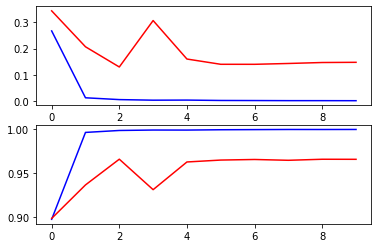

In [ ]:
f, ax = plt.subplots(2, 1) 
#Assign the first subplot to graph training loss and validation loss
ax[0].plot(att_model.history.history['loss'], color = 'b', label = 'Training Loss')
ax[0].plot(att_model.history.history['val_loss'], color = 'r', label = 'Validation Loss')

#Next lets plot the training accuracy and validation accuracy
ax[1].plot(att_model.history.history['accuracy'], color = 'b', label = 'Training  Accuracy')
ax[1].plot(att_model.history.history['val_accuracy'], color = 'r', label = 'Validation Accuracy')

In [ ]:
print(att_model.history.history)

{'loss': [0.26730790734291077, 0.011663527227938175, 0.0047352551482617855, 0.0025050328113138676, 0.0028655221685767174, 0.0014143551234155893, 0.0011130552738904953, 0.0007296601543202996, 0.0006887326599098742, 0.0005030907923355699], 'accuracy': [0.8970081210136414, 0.9964972734451294, 0.9987262487411499, 0.9992246627807617, 0.999183177947998, 0.9995569586753845, 0.9997092485427856, 0.9998615384101868, 0.999833881855011, 0.9998892545700073], 'val_loss': [0.34408363699913025, 0.20670686662197113, 0.12945084273815155, 0.3069903254508972, 0.1598566472530365, 0.13972622156143188, 0.1396646797657013, 0.142852783203125, 0.14654158055782318, 0.1472853124141693], 'val_accuracy': [0.898040235042572, 0.9363744854927063, 0.9658368825912476, 0.9309454560279846, 0.9626588821411133, 0.96484375, 0.965505838394165, 0.9645789265632629, 0.9657706618309021, 0.9657044410705566], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 1.0000001e-05, 1.0000001e-05, 1.0000001e-05, 1e-05]}


In [ ]:
!mv '/content/best_model.h5' '/content/drive/MyDrive/Handwash-Bot-Thesis/Code/Tencon/Models/Preprocess&Rescaled VGG16-SCAttention[Jul29_2022][INDICON].h5'

### Evaluate Code

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
#load model (optional)
att_model = load_model('/content/drive/MyDrive/Handwash-Bot-Thesis/Code/Tencon/Models/Preprocess&Rescaled VGG16-SCAttention[Jul29_2022][INDICON].h5')


In [ ]:
model=att_model

In [ ]:
train_gen = image_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=train_dir,
                                             shuffle=False,
                                             target_size=(NROW, NCOL),
                                             class_mode="categorical",
                                             classes=CLASS_NAMES,
                                             subset='training')

val_gen = image_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=train_dir,
                                             shuffle=False,
                                             target_size=(NROW, NCOL),
                                             class_mode="categorical",
                                             classes=CLASS_NAMES,
                                             subset='validation')

test_gen = test_image_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                              directory=test_dir,
                                              shuffle=False,
                                              target_size=(NROW, NCOL),
                                              class_mode="categorical",
                                              classes=CLASS_NAMES,
                                              seed=RANDOM_SEED)

Found 72357 images belonging to 6 classes.
Found 15208 images belonging to 6 classes.
Found 11980 images belonging to 6 classes.


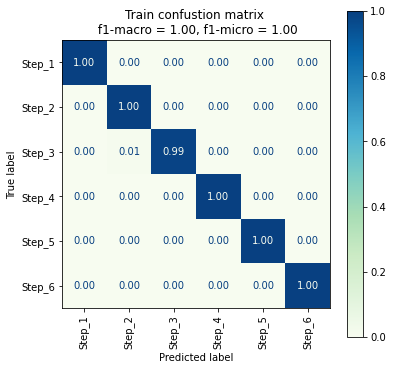

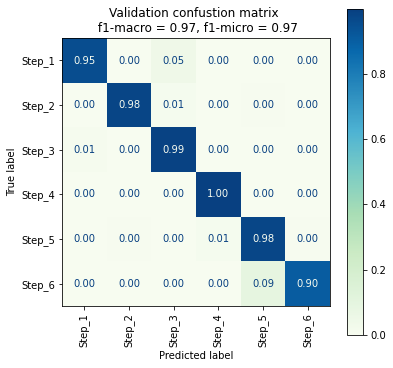

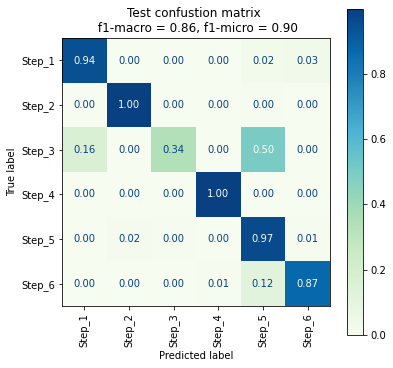

In [ ]:
plot_cf_matrix(att_model, train_gen, plot_title="Train confustion matrix", plot_size=(6,6))
plot_cf_matrix(att_model, val_gen, plot_title="Validation confustion matrix", plot_size=(6,6))
plot_cf_matrix(att_model, test_gen, plot_title="Test confustion matrix", plot_size=(6,6))

#Custom test data

In [ ]:
!mkdir -p '/content/HandWashDataset/custom'

In [ ]:
custom_test_1 = '/content/drive/MyDrive/Handwash-Bot-Thesis/Datasets/Kaggle/custom'
custom_test_2 = '/content/drive/MyDrive/Handwash-Bot-Thesis/Datasets/Kaggle/custom_test'
custom_test_3 = '/content/drive/MyDrive/Handwash-Bot-Thesis/Datasets/Kaggle/custom_test2' #TODO: rename test dir in drive later

In [ ]:
custom_test_gen_1 = test_image_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=custom_test_1,
                                             shuffle=False,
                                             target_size=(NROW, NCOL),
                                             class_mode="categorical",
                                             classes=CLASS_NAMES,
                                             seed=RANDOM_SEED)
custom_test_gen_2 = test_image_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=custom_test_2,
                                             shuffle=False,
                                             target_size=(NROW, NCOL),
                                             class_mode="categorical",
                                             classes=CLASS_NAMES,
                                             seed=RANDOM_SEED)
custom_test_gen_3 = test_image_datagen.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=custom_test_3,
                                             shuffle=False,
                                             target_size=(NROW, NCOL),
                                             class_mode="categorical",
                                             classes=CLASS_NAMES,
                                             seed=RANDOM_SEED)

Found 955 images belonging to 6 classes.
Found 1093 images belonging to 6 classes.
Found 1298 images belonging to 6 classes.


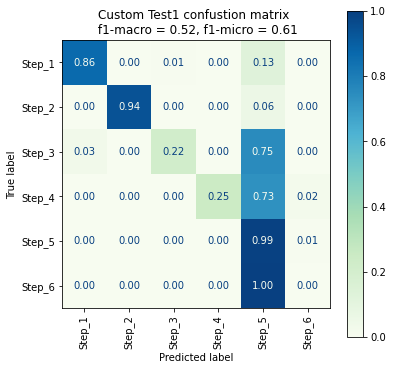

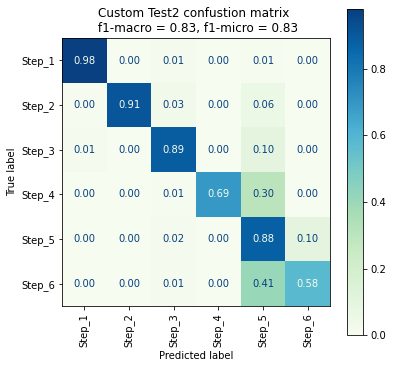

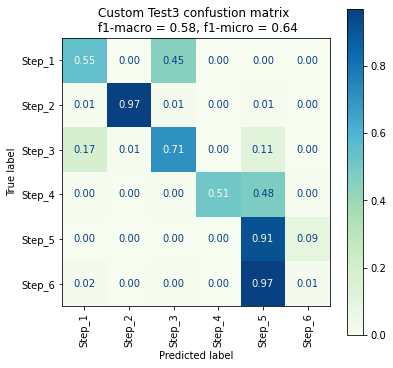

In [ ]:
plot_cf_matrix(att_model, custom_test_gen_1, plot_title="Custom Test1 confustion matrix", plot_size=(6,6))
plot_cf_matrix(att_model, custom_test_gen_2, plot_title="Custom Test2 confustion matrix", plot_size=(6,6))
plot_cf_matrix(att_model, custom_test_gen_3, plot_title="Custom Test3 confustion matrix", plot_size=(6,6))

**Attention Visualization**

### Saliency Map

In [ ]:
#@title Saliency Map Functions



subplot_args = { 'nrows': 1, 'ncols': NCLASS, 'figsize': (14, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }



# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(3, 7)` i.e., (samples, classes).
def loss(output):
    op =  tuple([output[i][i] for i in range(NCLASS)])
    return op

def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m


def saliency_plot(X, fname="saliency"):

    # Create Saliency object.
    saliency = Saliency(model,
                        model_modifier=model_modifier,
                        clone=False)

    # Generate saliency map with smoothing that reduce noise by adding noise
    saliency_map = saliency(loss,
                            X,
                            smooth_samples=20, # The number of calculating gradients iterations.
                            smooth_noise=0.20) # noise spread level.
    # saliency_map = normalize(saliency_map)
    saliency_map = standardize(saliency_map)
    visualize(saliency_map, CLASS_NAMES, plot_params=False, cmap='jet',
              savefig=True, fname=fname)
    return saliency_map



In [ ]:
# Loading Test data
for r in range(10):
    images = load_image_per_class('/content/test/')
    im_norm = preprocess_input(images)
    X = preprocess_norm(im_norm)
    X_fix_ch = X[:,:,:,::-1]   # interchange channels for plotting
    visualize(X_fix_ch, CLASS_NAMES, plot_params=False, suptitle="Salency on test data", savefig=True, fname=f"saliency_test_input_{r}")
    saliency_plot(X, fname=f"saliency_test_output_{r}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Loading Train data
for r in range(10):
    images = load_image_per_class('/content/train/')
    im_norm = preprocess_input(images)
    X = preprocess_norm(im_norm)
    X_fix_ch = X[:,:,:,::-1]   # interchange channels for plotting
    visualize(X_fix_ch, CLASS_NAMES, plot_params=False, suptitle="Salency on test data", savefig=True, fname=f"saliency_test_input_{r}")
    saliency_plot(X, fname=f"saliency_test_output_{r}")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Loading Train data
for r in range(10):
    images = load_image_per_class(custom_test_2+'/')
    im_norm = preprocess_input(images)
    X = preprocess_norm(im_norm)
    X_fix_ch = X[:,:,:,::-1]   # interchange channels for plotting
    visualize(X_fix_ch, CLASS_NAMES, plot_params=False, suptitle="Salency on test data", savefig=True, fname=f"saliency_test_input_{r}")
    saliency_plot(X, fname=f"saliency_test_output_{r}")

Output hidden; open in https://colab.research.google.com to view.